In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chi2_contingency
from datetime import datetime as datet

'fields.csv' |
'works.csv' |
 'values.csv'

# Baseline

In [26]:
df_fi = pd.read_csv('fields.csv', encoding='1251', sep=';', decimal=',')
df_fi = df_fi.drop(columns=['Unnamed: 18'])
df_fi = df_fi[df_fi['ph'] > 0]
df_fi = df_fi[df_fi['p2o5'] > 0]
df_fi = df_fi[df_fi['k2o'] > 0]
df_fi = df_fi[df_fi['humus'] > 0]

df_fi = df_fi.drop_duplicates(keep='first')

df_fi.head()

,field,region,land_type,fertility_score,season,crop,crop_predecessor,crop_yearold,area,hybrid,reproduction,seed_origin,technology,yield_plan,p2o5,k2o,humus,ph
0,22.47.01.001.01,Алтай,пашня,NaN,2023,Оз.пшеница мягкая,Пар; Яр.пшеница мягкая,NaN,306.22,Скипетр,ЭС,Покупные,минимальная,3.8,243.16,226.93,4.46,5.78
1,22.47.01.001.02,Алтай,пашня,NaN,2023,Пар,Пар; Яр.пшеница мягкая,NaN,63.16,NaN,NaN,NaN,минимальная,NaN,243.16,226.93,4.46,5.78
2,22.47.01.002.00,Алтай,пашня,4.0,2023,Пар,Яр.пшеница мягкая,NaN,485.79,NaN,NaN,NaN,NaN,NaN,219.78,204.60,3.85,5.72
3,22.47.01.003.00,Алтай,пашня,4.0,2023,Оз.пшеница мягкая,Пар,NaN,452.25,Скипетр,ЭС,Покупные,минимальная,3.8,205.15,192.28,6.49,5.94
4,22.47.01.004.00,Алтай,пашня,3.0,2023,Оз.пшеница мягкая,Пар,NaN,269.64,Скипетр,ЭС,Покупные,минимальная,3.8,183.26,162.69,6.16,5.94


In [27]:
df_fi.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10268 entries, 0 to 16052
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   field             10268 non-null  object 
 1   region            10268 non-null  object 
 2   land_type         10268 non-null  object 
 3   fertility_score   9952 non-null   float64
 4   season            10268 non-null  int64  
 5   crop              10268 non-null  object 
 6   crop_predecessor  10253 non-null  object 
 7   crop_yearold      2170 non-null   float64
 8   area              10268 non-null  float64
 9   hybrid            6802 non-null   object 
 10  reproduction      6319 non-null   object 
 11  seed_origin       6497 non-null   object 
 12  technology        6890 non-null   object 
 13  yield_plan        8561 non-null   float64
 14  p2o5              10268 non-null  float64
 15  k2o               10268 non-null  float64
 16  humus             10268 non-null  float64
 17

Добавим тип почвы

In [28]:
df_fi['season'].value_counts()

,count
season,
2023,5142
2024,5126


### Данных по обоим годам достаточно для анализа

### Все микроэлементы по нулям => мы ничего не можем с этим сделать (это 100% ошибка), значит, дропаем, по Башкирии данных немного

### Обработаем гумус

In [29]:
df_fi['humus'].describe()

,humus
count,10268.000000
mean,60.090389
std,103.989329
min,0.010000
25%,5.407500
50%,8.100000
75%,80.515000
max,1313.870000


### Гумус в процентном соотношении, значит больше 100% не может быть + удалим выбросы трехквантильным размахом

In [30]:
def fkkk():
    Q1 = df_fi['humus'].quantile(0.25)
    Q3 = df_fi['humus'].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df_fi['humus'] = df_fi['humus'].apply(lambda x: x if (x >= lower_bound) & (x <= upper_bound) else np.nan)
    print(df_fi['humus'].isna().sum())
    df_fi['humus'].describe()


df_fi = df_fi[df_fi['humus'] < 100]
fkkk()

913


<ipython-input-30-28f6dc9473d5>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fi['humus'] = df_fi['humus'].apply(lambda x: x if (x >= lower_bound) & (x <= upper_bound) else np.nan)


In [31]:
df_fi['humus'].describe()

,humus
count,7223.000000
mean,12.308192
std,14.551237
min,0.010000
25%,4.400000
50%,6.270000
75%,10.205000
max,61.390000


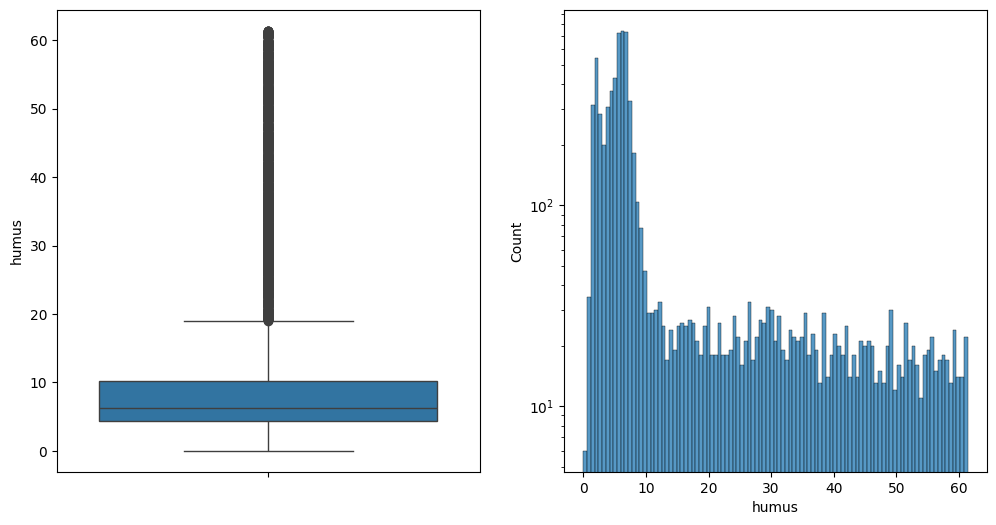

In [32]:
f, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.boxplot(df_fi['humus'], ax=ax[0])
sns.histplot(df_fi['humus'], ax=ax[1])
plt.yscale('log')

______

In [33]:
# df_fi.to_csv('fields_without_humus.csv', index=False)

In [34]:
dfw = pd.read_csv('works.csv', sep=';', encoding='1251')
dfw = dfw.drop_duplicates(keep='first')

df_fi['key'] = df_fi.apply(lambda x: (x.season, x.field), axis=1)
dfw['key'] = dfw.apply(lambda x: (x.season, x.field), axis=1)

In [35]:
print(len(dfw.key.unique()), len(df_fi.key.unique()))

12327 8136


### Имеем разное количество ключей между таблицами поля и выполненных над ними работ, значит по каким-то полям не имеем информации о проводимых над ними работах



______

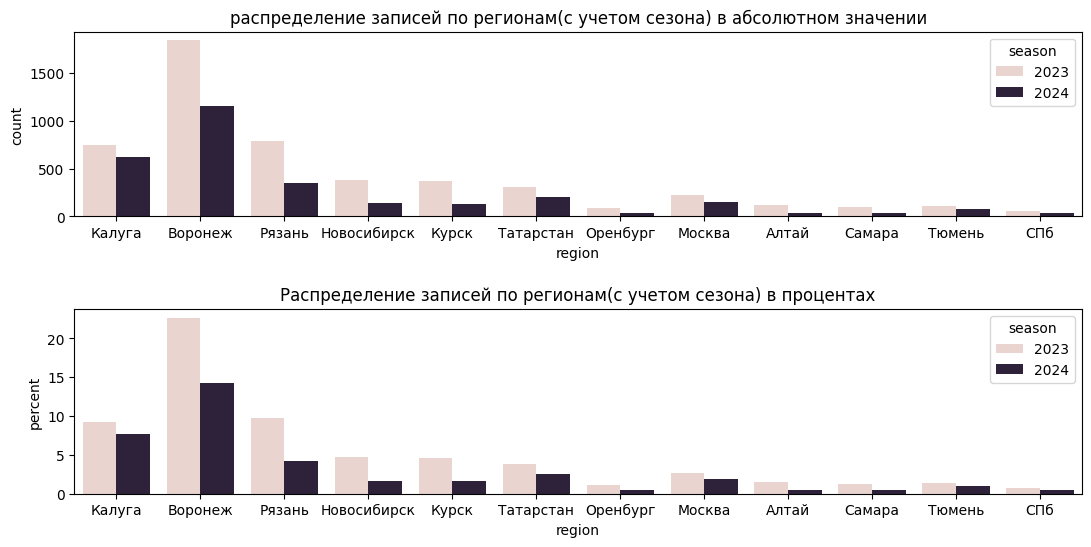

region
Воронеж        2995
Калуга         1372
Рязань         1132
Новосибирск     518
Татарстан       517
Курск           503
Москва          374
Тюмень          188
Алтай           161
Самара          141
Оренбург        133
СПб             102
Name: count, dtype: int64


In [36]:
order = ['Калуга', 'Воронеж', "Рязань", "Новосибирск", "Курск", "Татарстан", "Оренбург", "Москва", "Алтай", "Самара",
       "Тюмень", "СПб"]
dt = df_fi['region'].value_counts()
dtt = []
for reg in dt.keys():
    dtt.extend([reg] * dt[reg])
df_v = pd.DataFrame({'Регион': dtt})

f, ax = plt.subplots(2, 1, figsize=(13, 6))
# sns.histplot(df_v['Регион'])

sns.countplot(data=df_fi, x='region', hue='season', legend='auto', ax=ax[0], order=order)
ax[0].set_title('распределение записей по регионам(с учетом сезона) в абсолютном значении')

sns.countplot(data=df_fi, x='region', hue='season', legend='auto', ax=ax[1], stat='percent', order=order)
ax[1].set_title('Распределение записей по регионам(с учетом сезона) в процентах')

plt.subplots_adjust(hspace=0.5)
plt.show()
print(dt)

____________

Закончили с удалением данных

### Заполним наши NaN

In [37]:
# Группируем данные и рассчитываем среднее по 'humus'
hum_mean = df_fi.groupby(['region'])['humus'].mean()
# Заполняем пропуски в 'humus'
df_f = df_fi.copy() # для поиска корреляций без лишних медианных значений
df_fi['humus'] = df_fi['humus'].fillna(
    df_fi.apply(lambda x: hum_mean.get((x['region'])), axis=1)
)
# проверим на наличие nan после заполнения, вдруг ошибка какая была
print(df_fi.isna().sum())

field                  0
region                 0
land_type              0
fertility_score      237
season                 0
crop                   0
crop_predecessor      13
crop_yearold        6351
area                   0
hybrid              2962
reproduction        3354
seed_origin         3106
technology          2718
yield_plan          1397
p2o5                   0
k2o                    0
humus                  0
ph                     0
key                    0
dtype: int64


### Нельзя дропать crop_yearold, так как в нем указаны значения только для многолетних культур, для всех нанов можно указать значение = 0, так мы сможем отделять многолетние культуры от однолетних

In [38]:
df_fi['crop_yearold'] = df_fi['crop_yearold'].fillna(0)
df_fi['crop_yearold'].isna().sum()

0

In [39]:
df_fi['fertility_score'].value_counts()

,count
fertility_score,
3.0,3440
4.0,2676
2.0,715
5.0,662
1.0,374
0.0,32


In [40]:
# Группируем данные и рассчитываем среднее по 'fertility_score' и округляем до целого
fertility_score_mod = df_fi.groupby(['region'])['fertility_score'].agg(lambda x: np.round(x.mean()))
# Заполняем пропуски в 'fertility_score_mod'
df_fi['fertility_score'] = df_fi['fertility_score'].fillna(
    df_fi.apply(lambda x: fertility_score_mod.get((x['region'])), axis=1)
)
# проверим на наличие nan после заполнения, вдруг ошибка какая была
print(df_fi['fertility_score'].isna().sum())

0


In [41]:
df_fi['fertility_score'].value_counts()

,count
fertility_score,
3.0,3647
4.0,2706
2.0,715
5.0,662
1.0,374
0.0,32


In [42]:
# удалим строки, где неизвестна предшествующая культура

df_fi = df_fi.loc[~(df_fi['crop_predecessor'].isna())]
df_fi.isna().sum()

,0
field,0
region,0
land_type,0
fertility_score,0
season,0
crop,0
crop_predecessor,0
crop_yearold,0
area,0
hybrid,2951


In [43]:
df_fi['humus'].describe()

,humus
count,8123.000000
mean,12.287184
std,13.663194
min,0.010000
25%,4.730000
50%,6.600000
75%,13.114149
max,61.390000


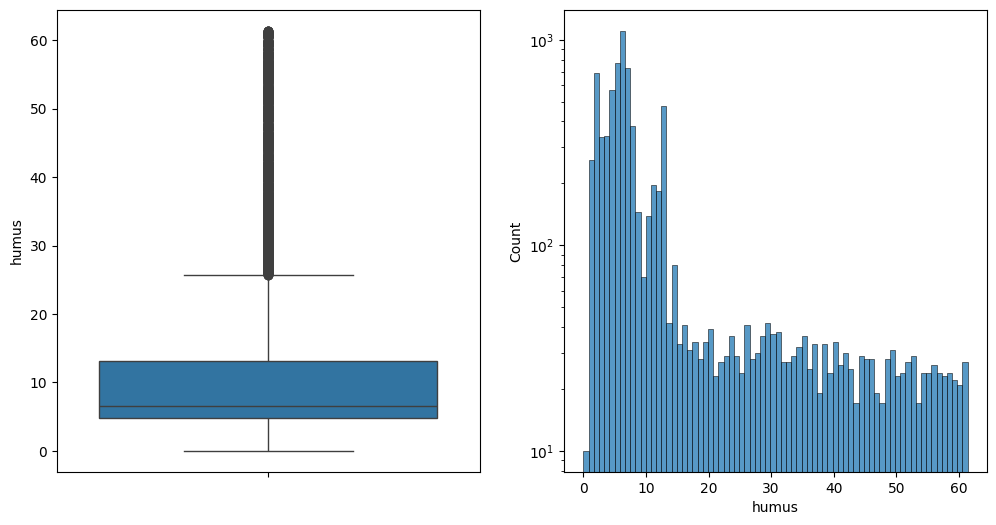

In [44]:
f, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.boxplot(df_fi['humus'], ax=ax[0])
sns.histplot(df_fi['humus'], ax=ax[1])
plt.yscale('log')

### распределение гумуса не поменялось, значит все пиздато

### Посмотрим NaNы

In [45]:
df_f.drop(columns='fertility_score').corr(numeric_only=1)

,season,crop_yearold,area,yield_plan,p2o5,k2o,humus,ph
season,1.000000,-0.109679,-0.249893,-0.016948,-0.718275,-0.120815,0.780181,-0.401292
crop_yearold,-0.109679,1.000000,0.024929,0.229906,0.105293,-0.045311,-0.055504,0.066106
area,-0.249893,0.024929,1.000000,-0.010400,0.254428,0.101245,-0.160283,0.095043
yield_plan,-0.016948,0.229906,-0.010400,1.000000,-0.012832,-0.023391,-0.022109,0.021944
p2o5,-0.718275,0.105293,0.254428,-0.012832,1.000000,0.329441,-0.520399,0.305390
k2o,-0.120815,-0.045311,0.101245,-0.023391,0.329441,1.000000,-0.058833,0.092200
humus,0.780181,-0.055504,-0.160283,-0.022109,-0.520399,-0.058833,1.000000,-0.285884
ph,-0.401292,0.066106,0.095043,0.021944,0.305390,0.092200,-0.285884,1.000000


### Пусть будет количественная для нашего вопроса, смлишком мало данных с большими годами (потом попробовать объединить до "менее 5 лет" и "5 и более лет" и найти корреляции)
### Дропнули, тк одни наны в корреляциях

### Посмотрим их взаимосвязи с другими характеристиками для решения по их изменению

In [46]:
def corr_cat(x, y): # функция для подсчета корреляции для 2х категориальных переменных
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ( (r-1)**2 / (n-1) )
    kcorr = k - ( (k-1)**2 / (n-1) )
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

'''
def coor_cat_num(numeric, categor): # функция для подсчета корреляции для категор/номинал
    df = df_f[[numeric, categor]].dropna()
    mezhgroup = vnutrigroup = 0
    meann = df[numeric].mean()
    for znach in set(df[categor].dropna()):
        data = pd.Series(df[df[categor] == znach][numeric]).dropna()
        vnutrigroup += sum([(elem - data.mean()) ** 2 for elem in data])
        mezhgroup += data.fillna(0).shape[0] * (pd.Series([data.mean()]).fillna(0)[0] - meann) ** 2
        print(znach)
    return (mezhgroup / (mezhgroup + vnutrigroup)) ** 0.5
    '''
def coor_cat_num(df, numeric, categor):
    mezhgroup = vnutrigroup = 0
    meann = df[numeric].mean()
    unique_categories = pd.Series(df[categor]).dropna().unique()
    for znach in unique_categories:
        data = df[df[categor] == znach][numeric].dropna()  # Фильтрация и удаление NaN для каждой категории
        if data.empty:
            continue  # Пропускаем категории без данных
        # Внутригрупповая дисперсия
        vnutrigroup += ((data - data.mean()) ** 2).sum()
        # Межгрупповая дисперсия
        mezhgroup += len(data) * (data.mean() - meann) ** 2
    return (mezhgroup / (mezhgroup + vnutrigroup)) ** 0.5

### Выведем значимые корреляции номинальных с категориальными

In [47]:
for cat in ['fertility_score', 'crop_predecessor', "hybrid", "reproduction", "seed_origin", "technology"]:
    print(cat + ":")
    for num in ['crop_yearold', 'area', 'yield_plan', 'p2o5', 'k2o', 'humus', 'ph']:
        if coor_cat_num(df_f[[num, cat]].dropna(), num, cat) > 0.3: # чтобы коркоэф имел хотя бы умеренное влияние
            print(f'{num}: {round(coor_cat_num(df_f[[num, cat]].dropna(), num, cat), 3)}', end='\t')
    for categ in ['region', 'land_type', 'season','crop']:
        if corr_cat(df_f[cat], df_f[categ]) > 0.3:
            print(f'{categ}: {round(corr_cat(df_f[cat], df_f[categ]), 3)}', end='\t')
    print()

fertility_score:
crop: 0.342	
crop_predecessor:
crop_yearold: 0.782	area: 0.378	ph: 0.4	region: 0.411	land_type: 0.944	crop: 0.53	
hybrid:
crop_yearold: 0.589	area: 0.366	yield_plan: 0.941	p2o5: 0.496	k2o: 0.393	humus: 0.473	ph: 0.536	region: 0.531	season: 0.497	crop: 0.635	
reproduction:
crop_yearold: 0.356	yield_plan: 0.413

<ipython-input-46-b41f90eb2754>:10: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


	crop: 0.429	
seed_origin:


<ipython-input-46-b41f90eb2754>:10: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
<ipython-input-46-b41f90eb2754>:10: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


crop: 0.632	
technology:
region: 0.499	crop: 0.385	


<ipython-input-46-b41f90eb2754>:10: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


### С очень большой вероятностью мы правильно подставим данные в crop_predecessor по land_type

In [ ]:
def fill_with_mode(group):
    mode_val = group.mode()
    return mode_val[0] if not mode_val.empty else np.nan

# Заполнение NaN в колонке crop_predecessor на основе land_type
df_fi['crop_predecessor'] = df_fi.groupby('land_type')['crop_predecessor'].transform(fill_with_mode)

Создадим функцию для замены NaN

In [ ]:
def repl_nan(col, dt_cols):
    global df_fi
    most_common = df_fi.groupby(dt_cols)[col].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None).rename("most_common")
    df_fi = df_fi.join(most_common, on=dt_cols)
    df_fi[col] = df_fi[col].fillna(df_fi["most_common"])
    df_fi.drop(columns="most_common", inplace=True)  # Удаляем временный столбец, если нужно

### Мы можем попробовать предугадать категорию hybrid из совокупности crop, region (или soil, их коркоэф почти равен 1, без разницы) и crop_yearold

In [ ]:
repl_nan('hybrid', ['crop', 'crop_yearold'])
repl_nan('hybrid', ['crop', 'region'])
repl_nan('hybrid', ['crop_yearold'])
repl_nan('hybrid', ['crop'])
repl_nan('hybrid', ['region'])
for col in df_fi.columns:
    if df_fi[col].isna().any(axis=0):
        print(f'{col}: {df_fi[col].isna().sum()}')

reproduction: 7473
seed_origin: 7205
technology: 6902
yield_plan: 4994


Так как создали функцию, комментим все ручные работы

In [ ]:
'''
most_common = df_fi.groupby(['crop'])['hybrid'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
df_fi['hybrid'] = df_fi['hybrid'].fillna(
    df_fi.apply(lambda x: most_common.get((x['crop'])), axis=1)
) # при понижении шага с crop_yearold появлялась ошибка OSError: could not get source code, от которой не удалось избавиться, так что перешел на менее точную версию
for col in df_fi.columns:
    if df_fi[col].isna().any(axis=0):
        print(f'{col}: {df_fi[col].isna().sum()}')
'''

hybrid: 3644
reproduction: 7473
seed_origin: 7205
technology: 6902
yield_plan: 4994


In [ ]:
print(f'hybrid: {df_fi["hybrid"].isna().sum()}')

hybrid: 0


### Далее seed_origin по crop

In [ ]:
repl_nan('seed_origin', ['crop'])
print(f'seed_origin: {df_fi["seed_origin"].isna().sum()}')

seed_origin: 649


### Тк он больше ни с кем нормально не коррелирует, то дропаем эти NaNы

In [ ]:
df_fi = df_fi.dropna(subset='seed_origin')

### Теперь technology

In [ ]:
corr_cat(df_f['hybrid'], df_f["technology"]) # просто проверю

0.4898110970853735

In [ ]:
repl_nan('technology', ['crop', 'region'])
repl_nan('technology', ['hybrid', 'region'])
repl_nan('technology', ['crop'])

"\nmost_common = df_fi.groupby(['crop', 'region'])['technology'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)\ndf_fi['technology'] = df_fi['technology'].fillna(\n    df_fi.apply(lambda x: most_common.get((x['crop'], x['region'])), axis=1)\n)\n"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print(f'technology: {df_fi["technology"].isna().sum()}')

technology: 0


In [ ]:
for col in df_fi.columns:
    if df_fi[col].isna().any(axis=0):
        print(f'{col}: {df_fi[col].isna().sum()}')

reproduction: 6828
yield_plan: 4487


yield_plan:

In [ ]:
repl_nan('yield_plan', ['crop_yearold', 'area'])
repl_nan('yield_plan', ['crop_yearold'])

count    14596.000000
mean       355.451262
std        701.082630
min          0.620000
25%         57.587500
50%        171.102150
75%        407.144000
max      16959.600000
Name: yield_plan_full, dtype: float64


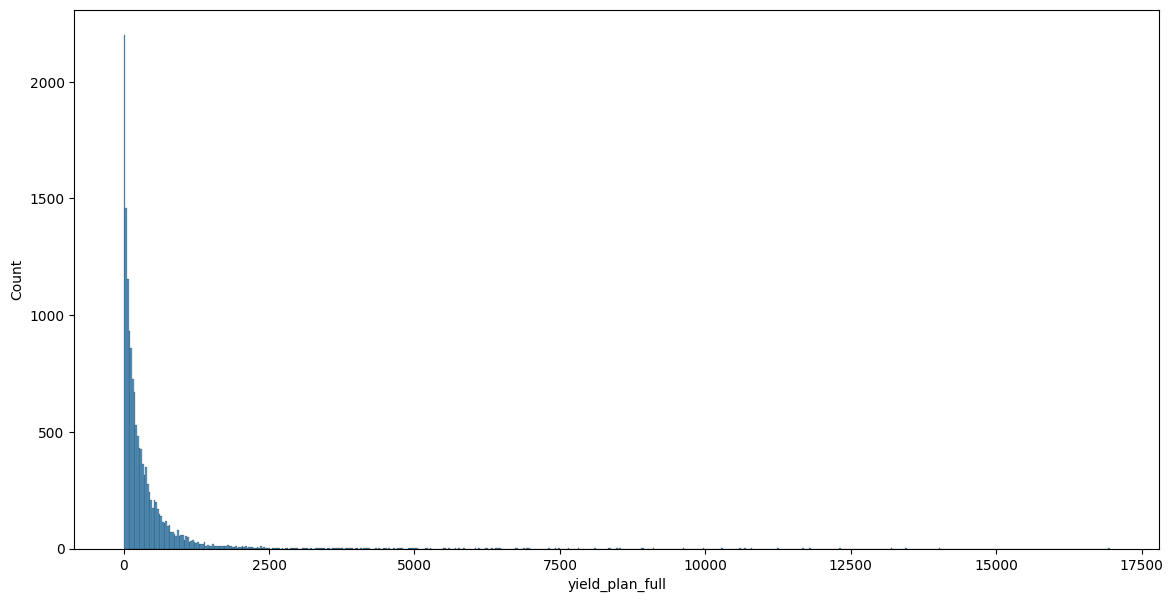

In [ ]:
df_fi['yield_plan_full'] = df_fi.apply(lambda x: x.area * x.yield_plan, axis=1)
f, ax = plt.subplots(1, 1, figsize=(14, 7))
sns.histplot(df_fi['yield_plan_full'])
print(df_fi['yield_plan_full'].describe())

''' Игнат сказал пока что не удалять выбросы
def fkkk(): ## уберем выбросы
    Q1 = df_fi['yield_plan_full'].quantile(0.25)
    Q3 = df_fi['yield_plan_full'].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR

    df_fi['yield_plan_full'] = df_fi['yield_plan_full'].apply(lambda x: x if (x >= lower_bound) & (x <= upper_bound) else np.nan)
    print(df_fi['yield_plan_full'].isna().sum(), df_fi.shape) # на фоне общего размера НаНов немного, значт дропать можно
    df_fi.dropna(subset='yield_plan_full', inplace=True)


fkkk()
sns.histplot(df_fi['yield_plan_full'], ax=ax[1])
plt.show()
'''
df_fi['yield_plan_full_cat'] = df_fi['yield_plan_full'].apply(lambda x: 0.25 if x < df_fi['yield_plan_full'].quantile(0.25)
                                                          else 0.5 if x < df_fi['yield_plan_full'].quantile(0.5)
                                                          else 0.75 if x < df_fi['yield_plan_full'].quantile(0.75)
                                                          else 1)

In [ ]:
repl_nan('reproduction', ['crop', 'crop_yearold'])
'''
# удаляет только десяток из 300 оставшихся нанов + неточно => легче удалить

most_common = df_fi.groupby(['crop', 'yield_plan'])['reproduction'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
df_fi['reproduction'] = df_fi['reproduction'].fillna(
    df_fi.apply(lambda x: most_common.get((x['crop'], x['yield_plan'])), axis=1)
)
'''
df_fi.dropna(subset='reproduction', inplace=True)

In [48]:
for col in df_fi.columns:
    if df_fi[col].isna().any(axis=0):
        print(f'{col}: {df_fi[col].isna().sum()}')

hybrid: 2951
reproduction: 3343
seed_origin: 3096
technology: 2708
yield_plan: 1387


________________________________________________________________________________________________________________________

Просто создам функцию для будущего подсчета выбросов

In [49]:
def del_outs(col):
    iqr = 1.5 * (df_fi[col].quantile(0.75) - df_fi[col].quantile(0.25))
    meann = df_fi[col].mean()
    df_fi[col] = df_fi[col].apply(lambda x: x if meann - iqr <= x <= meann + iqr
                                  else np.nan, axis=1)

________________________________________________________________

Посмотрим различные графики

In [50]:
df_fi.corr(numeric_only=True)

,fertility_score,season,crop_yearold,area,yield_plan,p2o5,k2o,humus,ph
fertility_score,1.000000,-0.051676,-0.030790,0.087555,0.063801,0.107555,0.138775,-0.000746,0.191274
season,-0.051676,1.000000,-0.000185,-0.251777,-0.016905,-0.717968,-0.120338,0.691263,-0.402456
crop_yearold,-0.030790,-0.000185,1.000000,-0.036398,-0.102846,-0.009279,-0.083467,-0.008559,-0.021955
area,0.087555,-0.251777,-0.036398,1.000000,-0.010192,0.255743,0.101965,-0.162708,0.094047
yield_plan,0.063801,-0.016905,-0.102846,-0.010192,1.000000,-0.012933,-0.023529,-0.019978,0.022052
p2o5,0.107555,-0.717968,-0.009279,0.255743,-0.012933,1.000000,0.329216,-0.490814,0.306080
k2o,0.138775,-0.120338,-0.083467,0.101965,-0.023529,0.329216,1.000000,-0.056828,0.092451
humus,-0.000746,0.691263,-0.008559,-0.162708,-0.019978,-0.490814,-0.056828,1.000000,-0.257921
ph,0.191274,-0.402456,-0.021955,0.094047,0.022052,0.306080,0.092451,-0.257921,1.000000


______________________________________

Посмотрим полную матрицу корреляций:

In [51]:
corr_matrix = pd.DataFrame(index=df_fi.drop(columns=['key']).columns, columns=df_fi.drop(columns=['key']).columns)
for i in range(corr_matrix.shape[0]):
    for j in range(corr_matrix.shape[0]):
        fir, sec = df_fi.drop(columns=['key']).columns[i], df_fi.drop(columns=['key']).columns[j]
        print(fir, sec)
        if fir == sec:
            corr_matrix.iat[i, j] = 1
            continue
        if df_fi.dtypes[fir] == object:
            if df_fi.dtypes[sec] == object:
                corr_matrix.iat[i, j] = corr_cat(df_fi[fir], df_fi[sec])
            else:
                corr_matrix.iat[i, j] = coor_cat_num(df_fi, sec, fir)
        else:
            if df_fi.dtypes[sec] == object:
                corr_matrix.iat[i, j] = coor_cat_num(df_fi, fir, sec)
            else: corr_matrix.iat[i, j] = df_fi.corr(numeric_only=1)[fir][sec]


field field
field region
field land_type
field fertility_score
field season
field crop
field crop_predecessor
field crop_yearold
field area
field hybrid
field reproduction
field seed_origin
field technology
field yield_plan
field p2o5
field k2o
field humus
field ph
region field
region region
region land_type
region fertility_score
region season
region crop
region crop_predecessor
region crop_yearold
region area
region hybrid
region reproduction
region seed_origin
region technology
region yield_plan
region p2o5
region k2o
region humus
region ph
land_type field
land_type region
land_type land_type
land_type fertility_score
land_type season
land_type crop
land_type crop_predecessor
land_type crop_yearold
land_type area
land_type hybrid
land_type reproduction
land_type seed_origin
land_type technology
land_type yield_plan
land_type p2o5
land_type k2o
land_type humus
land_type ph
fertility_score field


<ipython-input-46-b41f90eb2754>:10: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
<ipython-input-46-b41f90eb2754>:10: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
<ipython-input-46-b41f90eb2754>:10: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
<ipython-input-46-b41f90eb2754>:10: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


fertility_score region
fertility_score land_type
fertility_score fertility_score
fertility_score season
fertility_score crop
fertility_score crop_predecessor
fertility_score crop_yearold
fertility_score area
fertility_score hybrid
fertility_score reproduction
fertility_score seed_origin
fertility_score technology
fertility_score yield_plan
fertility_score p2o5
fertility_score k2o
fertility_score humus
fertility_score ph
season field
season region
season land_type
season fertility_score
season season
season crop
season crop_predecessor
season crop_yearold
season area
season hybrid
season reproduction
season seed_origin
season technology
season yield_plan
season p2o5
season k2o
season humus
season ph
crop field
crop region
crop land_type
crop fertility_score
crop season
crop crop
crop crop_predecessor
crop crop_yearold
crop area
crop hybrid
crop reproduction
crop seed_origin
crop technology
crop yield_plan
crop p2o5
crop k2o
crop humus
crop ph
crop_predecessor field
crop_predecessor regi

<ipython-input-46-b41f90eb2754>:10: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


hybrid season
hybrid crop
hybrid crop_predecessor
hybrid crop_yearold
hybrid area
hybrid hybrid
hybrid reproduction
hybrid seed_origin
hybrid technology
hybrid yield_plan
hybrid p2o5
hybrid k2o
hybrid humus
hybrid ph
reproduction field
reproduction region
reproduction land_type
reproduction fertility_score
reproduction season
reproduction crop
reproduction crop_predecessor


<ipython-input-46-b41f90eb2754>:10: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


reproduction crop_yearold
reproduction area
reproduction hybrid
reproduction reproduction
reproduction seed_origin
reproduction technology
reproduction yield_plan
reproduction p2o5
reproduction k2o
reproduction humus
reproduction ph
seed_origin field
seed_origin region
seed_origin land_type
seed_origin fertility_score
seed_origin season
seed_origin crop
seed_origin crop_predecessor
seed_origin crop_yearold
seed_origin area
seed_origin hybrid


<ipython-input-46-b41f90eb2754>:10: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


seed_origin reproduction
seed_origin seed_origin
seed_origin technology
seed_origin yield_plan
seed_origin p2o5
seed_origin k2o
seed_origin humus
seed_origin ph
technology field
technology region
technology land_type
technology fertility_score


<ipython-input-46-b41f90eb2754>:10: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


technology season
technology crop
technology crop_predecessor
technology crop_yearold
technology area
technology hybrid
technology reproduction
technology seed_origin
technology technology
technology yield_plan
technology p2o5
technology k2o
technology humus
technology ph
yield_plan field
yield_plan region
yield_plan land_type
yield_plan fertility_score
yield_plan season
yield_plan crop
yield_plan crop_predecessor
yield_plan crop_yearold
yield_plan area
yield_plan hybrid
yield_plan reproduction
yield_plan seed_origin
yield_plan technology
yield_plan yield_plan
yield_plan p2o5
yield_plan k2o
yield_plan humus
yield_plan ph
p2o5 field
p2o5 region
p2o5 land_type
p2o5 fertility_score
p2o5 season
p2o5 crop
p2o5 crop_predecessor
p2o5 crop_yearold
p2o5 area
p2o5 hybrid
p2o5 reproduction
p2o5 seed_origin
p2o5 technology
p2o5 yield_plan
p2o5 p2o5
p2o5 k2o
p2o5 humus
p2o5 ph
k2o field
k2o region
k2o land_type
k2o fertility_score
k2o season
k2o crop
k2o crop_predecessor
k2o crop_yearold
k2o area
k

In [52]:
for col in corr_matrix:
    corr_matrix[col] = corr_matrix[col].apply(float)

ValueError: The condensed distance matrix must contain only finite values.

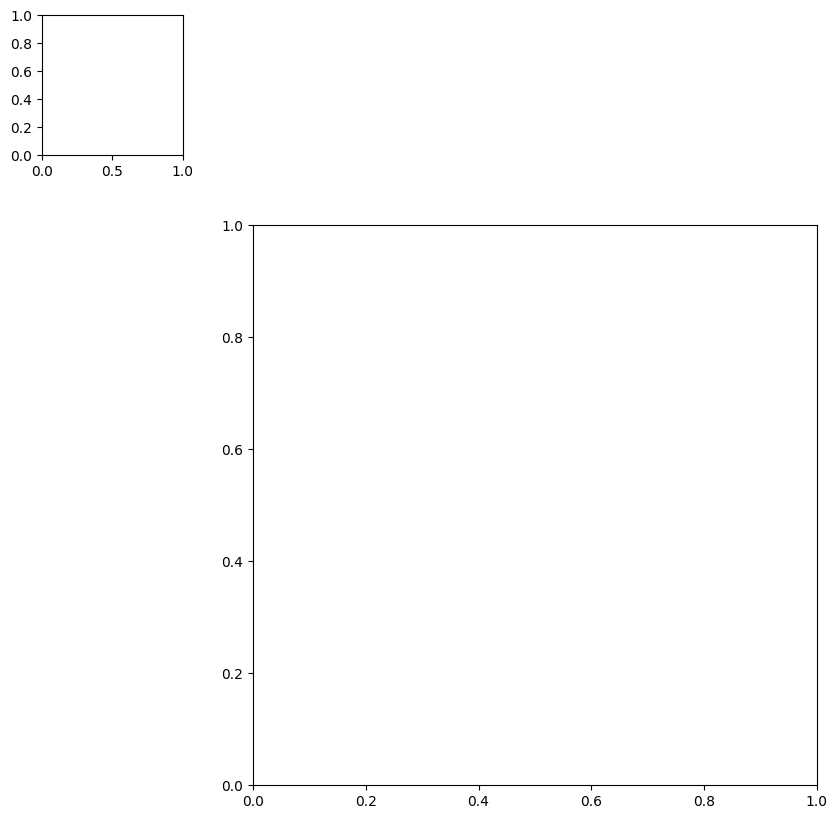

In [53]:
sns.clustermap(corr_matrix.round(1), annot=True, cmap='plasma', vmin=-1)

In [ ]:
corr_matrix.to_csv('corr_matrix.csv', index=0)

In [54]:
corr_matrix.iat[i, j] = corr_cat(df_fi['field'], df_fi['key'])

TypeError: Cannot broadcast np.ndarray with operand of type <class 'list'>

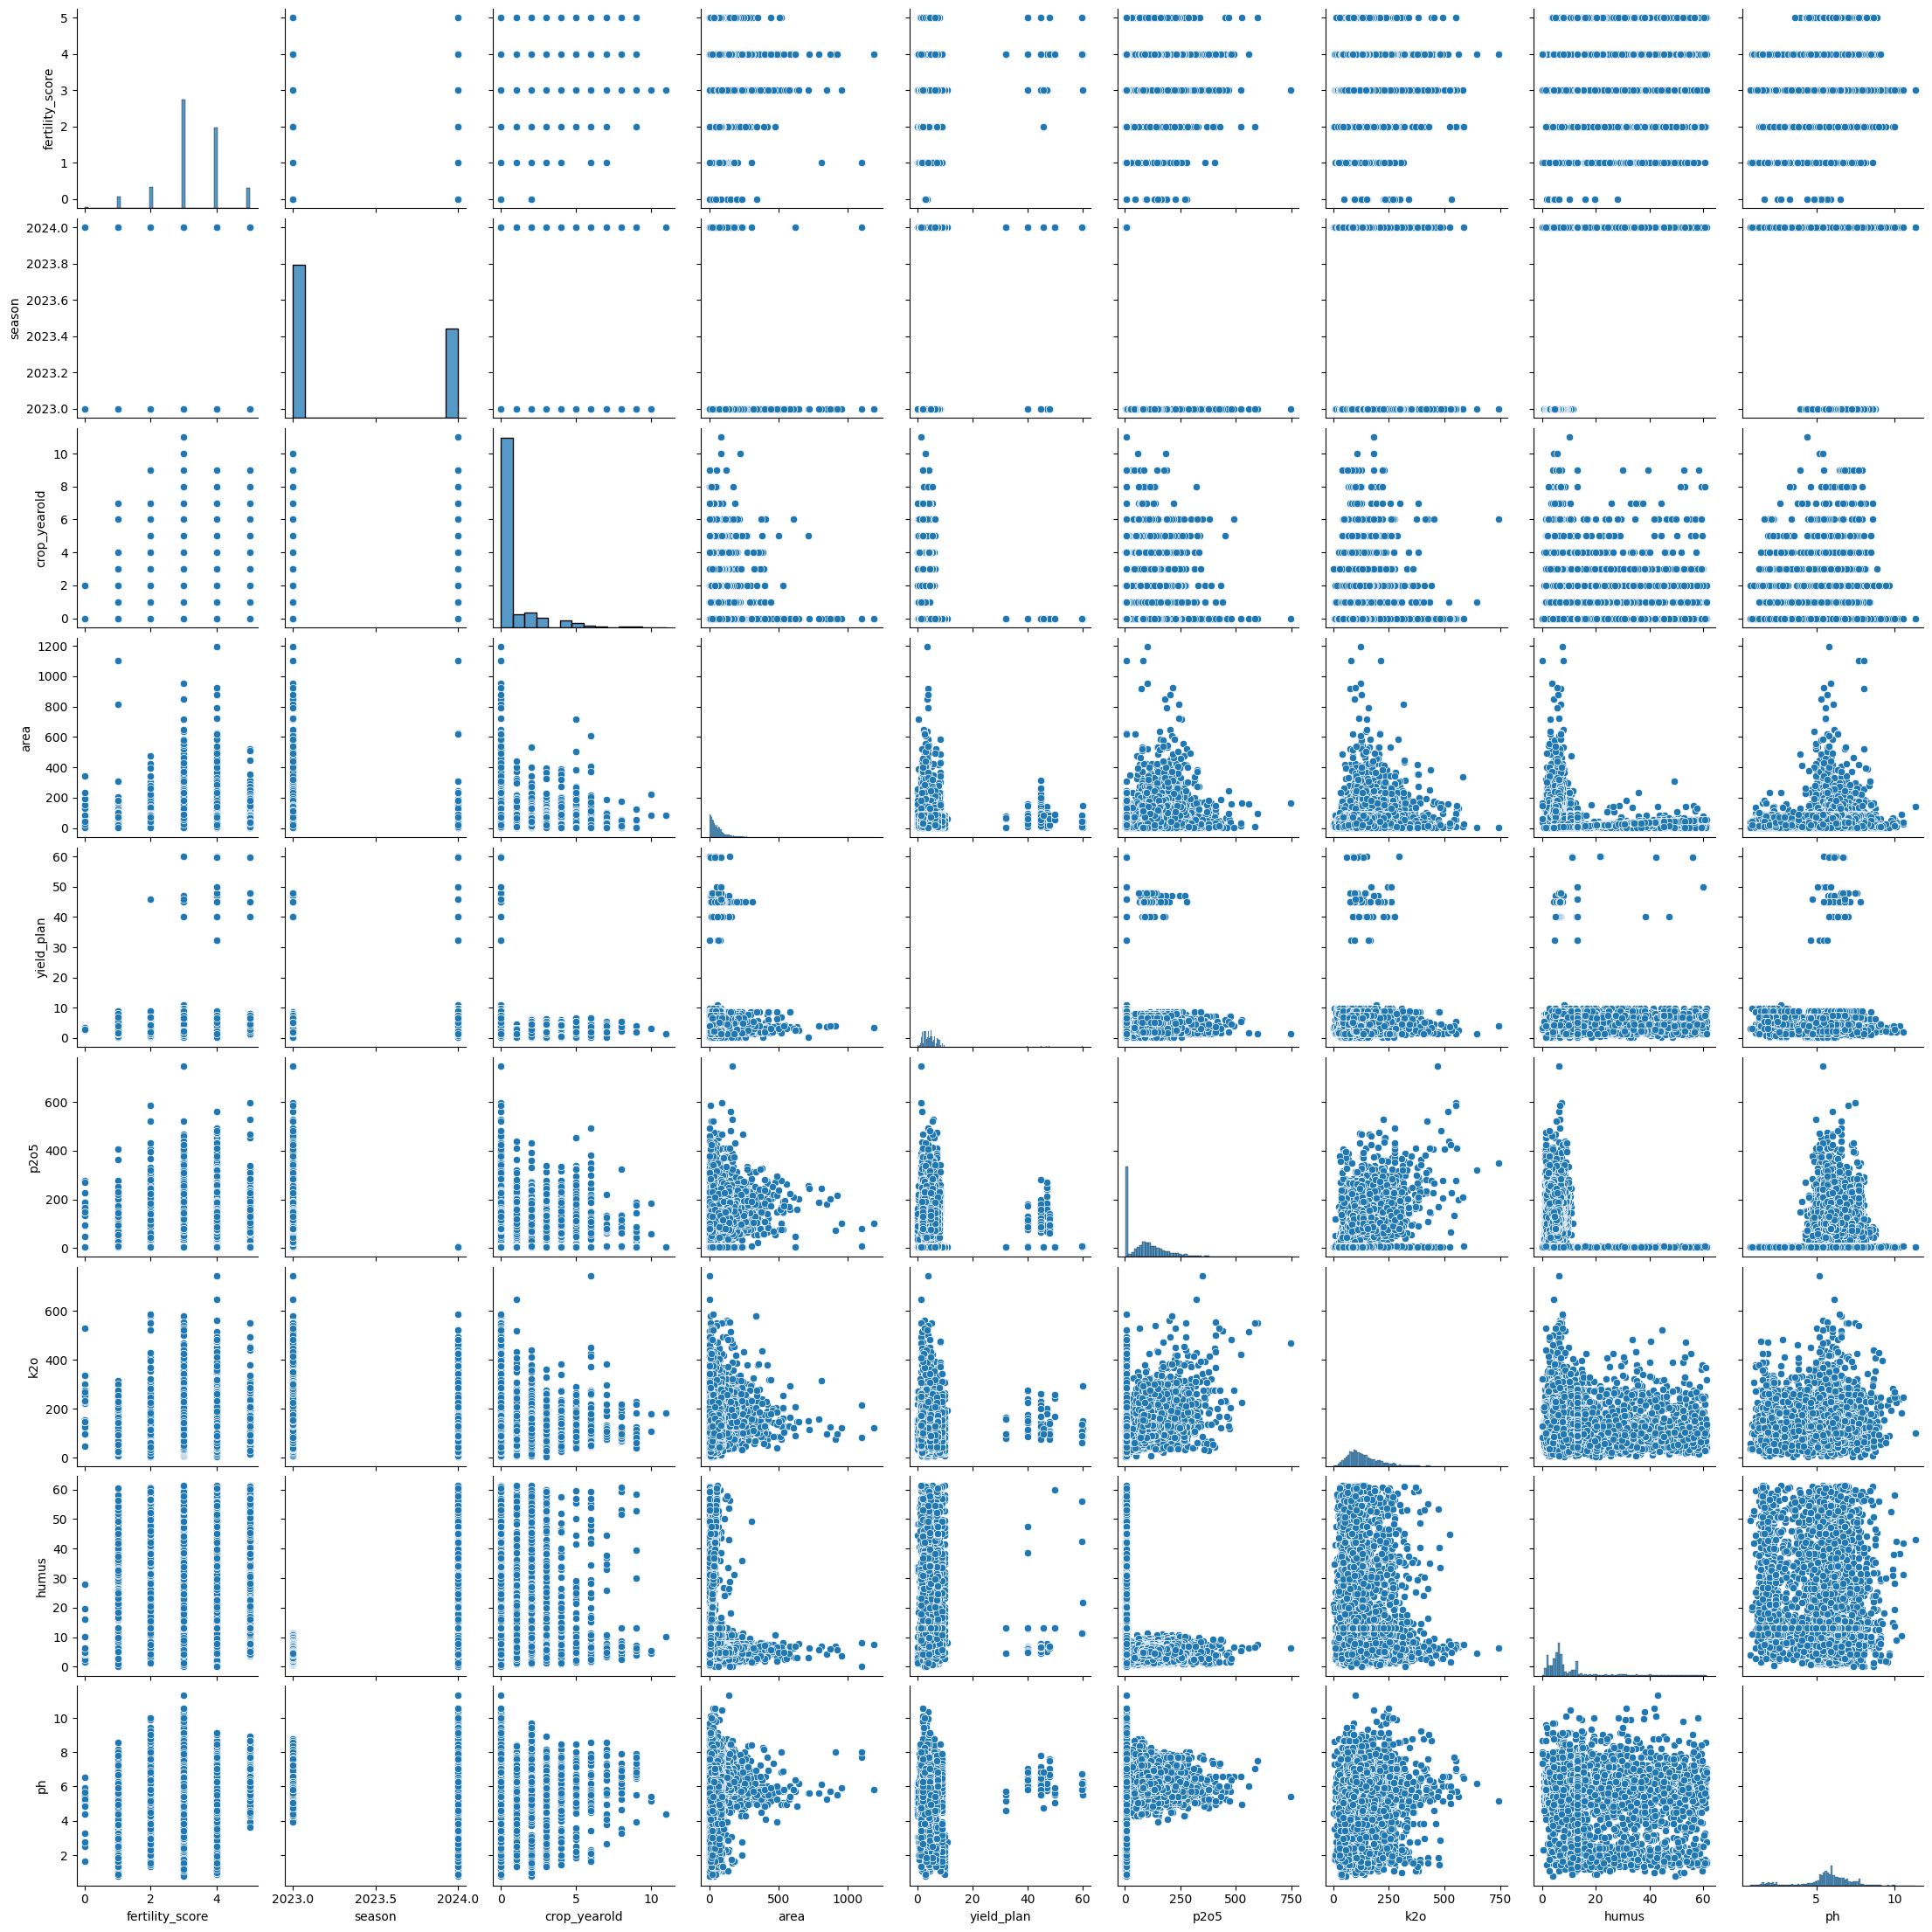

In [55]:
sns.pairplot(df_fi)
plt.show()

In [ ]:
dfw.head(2)

,season,field,work_type,work_subtype,start_date,end_date,area,main_tech,add_tech,mech,proc_depth,prod_purpose,prod_weight,prod_dry_perc,prod_humid,prod_impur,yield_fact,work_id,key
0,2023,16.13.12.044.00,Обработка почвы,Боронование,29.04.2022,30.04.2022,"49,78","Трактор колесный Fendt 936 Vario, гос.ном. 050...",Арендованная техника,Ахметсафин Айрат Рафикович,"10,00",NaN,"0,00",NaN,NaN,NaN,"0,00",A06AD38A-5448-40EC-B095-4B8918B4AC10,"(2023, 16.13.12.044.00)"
1,2023,16.13.12.017.00,Обработка почвы,Боронование,01.05.2022,02.05.2022,"154,76","Трактор колесный Птз К-744Р4, гос.ном. 2251АА1...","Борона зубовая Veles АГС-22-2У.М, зав.ном. 789",Ямалетдинов Фарид Расыхович,"10,00",NaN,"0,00",NaN,NaN,NaN,"0,00",62B13DCE-FFB5-4E7A-8F1B-88930BD338EF,"(2023, 16.13.12.017.00)"


In [ ]:
dfw.isna().sum()

,0
season,0
field,0
work_type,0
work_subtype,0
start_date,0
end_date,9003
area,0
main_tech,0
add_tech,48534
mech,0


In [ ]:
dfw.dtypes

,0
season,int64
field,object
work_type,object
work_subtype,object
start_date,object
end_date,object
area,object
main_tech,object
add_tech,object
mech,object


In [ ]:
#dfw['start_date'] = dfw['start_date'].apply(lambda x:datet.strptime(str(x), '%d.%m.%Y %H:%M:%d'))
#dfw['end_date'] = dfw['end_date'].apply(lambda x:datet.strptime(str(x), '%d.%m.%Y'))

error: redefinition of group name 'd' as group 6; was group 1 at position 136